In [1]:
import numpy as np
from skimage.transform import pyramid_gaussian
from skimage.io import imread, imshow, imsave
from skimage import img_as_float
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_shifts (channel_a, channel_b, row_shift_range, col_shift_range):
    min_row_shift, max_row_shift = row_shift_range
    min_col_shift, max_col_shift = col_shift_range
    
    direction = -1
    
    max_corr = None
    best_row_shift = 0
    best_col_shift = 0
    
    a_shifted = np.roll(channel_a, min_row_shift - 1, axis=0)
    a_shifted = np.roll(a_shifted, min_col_shift - 1, axis=1)
    
    for row_shift in range(min_row_shift, max_row_shift + 1):
        a_shifted = np.roll(a_shifted,1,axis=0)

        direction = -direction
        
        if direction == -1:
            min_col_shift, max_col_shift = max_col_shift, min_col_shift
        
        for col_shift in range(min_col_shift, max_col_shift + direction,direction):
            a_shifted = np.roll(a_shifted,direction,axis=1)
            
            a_list = a_shifted.flatten()
            b_list = channel_b.flatten()
            
            cur_corr = np.sum((a_list * b_list)) / (np.sqrt((np.sum(a_list**2)) * (np.sum(b_list**2))))
            
            if max_corr == None or max_corr < cur_corr:
                max_corr = cur_corr
                best_row_shift = row_shift
                best_col_shift = col_shift
            
        if direction == -1:
            min_col_shift, max_col_shift = max_col_shift, min_col_shift
    
    return (best_row_shift, best_col_shift)

In [4]:
def pyramid_search(channel_a, channel_b):
    if channel_a.shape[0] < 2000:
        depth = 1
    else:
        depth = 5
    pyramid_a = tuple(pyramid_gaussian(channel_a, max_layer=depth,downscale=2,multichannel=False))
    pyramid_b = tuple(pyramid_gaussian(channel_b, max_layer=depth,downscale=2,multichannel=False))
    
    row_shift_range = (-15,15)
    col_shift_range = (-15,15)
    
    for current_a, current_b in reversed(list(zip(pyramid_a, pyramid_b))):
        cur_shift = get_shifts(current_a, current_b, row_shift_range, col_shift_range)
        row_shift_range = (cur_shift[0] * 2 - 2, cur_shift[0] * 2 + 2)
        col_shift_range = (cur_shift[1] * 2 - 2, cur_shift[1] * 2 + 2)
    
    return cur_shift

In [20]:
def align (img, g_coord):
    img = img_as_float(img)
    row_g, col_g = g_coord
    img_h, img_w = img.shape
    
    channel_h = img_h // 3
    b = img[:channel_h,]
    g = img[channel_h:channel_h * 2,]
    r = img[channel_h * 2:channel_h * 3,]
    
    vert_edge = int(channel_h * 0.1)
    hor_edge = int(img_w * 0.1)
    b = b[vert_edge:-vert_edge,hor_edge:-hor_edge]
    g = g[vert_edge:-vert_edge,hor_edge:-hor_edge]
    r = r[vert_edge:-vert_edge,hor_edge:-hor_edge]
    
    shift_y_b, shift_x_b = pyramid_search(b,g)
    shift_y_r, shift_x_r = pyramid_search(r,g)
    
    b = np.roll(b,shift_y_b,axis=0)
    b = np.roll(b,shift_x_b,axis=1)
    r = np.roll(r,shift_y_r,axis=0)
    r = np.roll(r,shift_x_r,axis=1)
    
    #print(shift_y_r,shift_x_r,shift_y_b,shift_x_b)
    dest = np.dstack((r,g,b))
    #imshow(dest)
    
    row_b = row_g - shift_y_b - channel_h
    col_b = col_g - shift_x_b
    row_r = row_g - shift_y_r + channel_h
    col_r = col_g - shift_x_r
    
    return dest, (row_b, col_b), (row_r, col_r)

In [13]:
def align_2 (img, g_coord):
    import numpy 
    from skimage import img_as_float
    
    img = img_as_float(img)
    row_g, col_g = g_coord
    img_h, img_w = img.shape
    
    channel_h = img_h // 3
    b = img[:channel_h,]
    g = img[channel_h:channel_h * 2,]
    r = img[channel_h * 2:channel_h * 3,]
    
    vert_edge = int(channel_h * 0.1)
    hor_edge = int(img_w * 0.1)
    b = b[vert_edge:-vert_edge,hor_edge:-hor_edge]
    g = g[vert_edge:-vert_edge,hor_edge:-hor_edge]
    r = r[vert_edge:-vert_edge,hor_edge:-hor_edge]
    
    
    #max_corr = 0
    #shift_x_b = 0
    #shift_y_b = 0
    #for x in range(-15,16):
    #    for y in range(-15,16):
    #        b_tmp = np.roll(b,y,axis=0)
    #        b_tmp = np.roll(b_tmp,x,axis=1)
    #        corr = (b_tmp * g).sum()
    #        if corr > max_corr:
    #            max_corr = corr
    #            shift_x_b = x
    #            shift_y_b = y
                
    #max_corr = 0
    #shift_x_r = 0
    #shift_y_r = 0
    #for x in range(-15,16):
    #    for y in range(-15,16):
    #        r_tmp = np.roll(r,y,axis=0)
    #        r_tmp = np.roll(r_tmp,x,axis=1)
    #        corr = (r_tmp * g).sum()
    #        if corr > max_corr:
    #            max_corr = corr
    #            shift_x_r = x
    #            shift_y_r = y
    
    shift_x_b = 0
    shift_y_b = 0
    shift_x_r = 0
    shift_y_r = 0
    
    g_list = g.flatten()
    
    cross_b_max = 0
    for x in range(-15,16):
        for y in range(-15,16):
            b_tmp = numpy.roll(b,y,axis=0)
            b_tmp = numpy.roll(b_tmp,x,axis=1)
            b_list = b_tmp.flatten()
            cross_b = numpy.sum((g_list*b_list))/(numpy.sqrt((numpy.sum(g_list**2))*(numpy.sum(b_list**2))))
            if cross_b > cross_b_max:
                cross_b_max = cross_b
                shift_x_b = x
                shift_y_b = y
                
    cross_r_max = 0
    for x in range(-15,16):
        for y in range(-15,16):
            r_tmp = numpy.roll(r,y,axis=0)
            r_tmp = numpy.roll(r_tmp,x,axis=1)
            r_list = r_tmp.flatten()
            cross_r = numpy.sum((g_list*r_list))/(numpy.sqrt((numpy.sum(g_list**2))*(numpy.sum(r_list**2))))
            if cross_r > cross_r_max:
                cross_r_max = cross_r
                shift_x_r = x
                shift_y_r = y
    
    #shift_y_b, shift_x_b = get_shifts(b,g,(-15,15),(-15,15))
    #shift_y_r, shift_x_r = get_shifts(r,g,(-15,15),(-15,15))
    
    b = numpy.roll(b,shift_y_b,axis=0)
    b = numpy.roll(b,shift_x_b,axis=1)
    r = numpy.roll(r,shift_y_r,axis=0)
    r = numpy.roll(r,shift_x_r,axis=1)
    #print(shift_y_r,shift_x_r,shift_y_b,shift_x_b)
    
    dest = np.dstack((r,g,b))
    #imshow(dest)
    
    row_b = row_g - shift_y_b - channel_h
    col_b = col_g - shift_x_b
    row_r = row_g - shift_y_r + channel_h
    col_r = col_g - shift_x_r
    
    return dest, (row_b, col_b), (row_r, col_r)

In [18]:
def main():
    img = imread('11.png')
    plt.figure(figsize=(10,10))
    fin, coord_b, coord_r = align(img, (4588, 2617))
    print(coord_b, coord_r)
    imshow(fin)

9763
(1362, 2623) (7766, 2610)


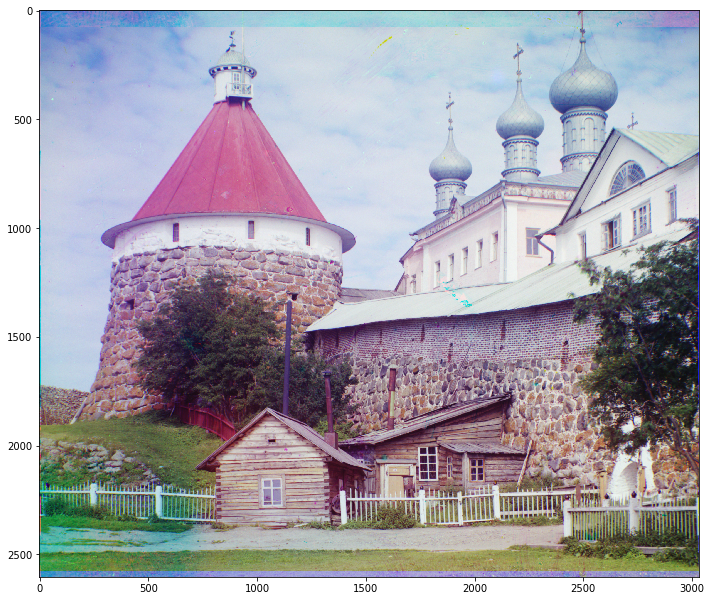

In [19]:
main()